# <h1><center><strong>$$\color{#4740BF}{\text{Useful libraries}}$$<strong>


In [ ]:
import numpy as np # linear algebra  
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import os
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow import keras 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional # , TimeDistributed
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/progetto text mining/CSV/new_train2.csv')
test = pd.read_csv('/content/drive/MyDrive/progetto text mining/CSV/new_test2.csv')

In [ ]:
train.isnull().sum()
train.dropna(inplace=True)
train.reset_index(drop=True, inplace=True)
train.isnull().sum()

test.isnull().sum()
test.dropna(inplace=True)
test.reset_index(drop=True, inplace=True)
test.isnull().sum()


label     0
review    0
dtype: int64

# <h1><center><strong>$$\color{#4740BF}{\text{2. Neural Network model for classification}}$$<strong>


## <h1><center><strong>$$\color{#4740BF}{\text{BiLSTM on 5 categories}}$$<strong>



Here we start the processing of the data in order to prepared them for implementing a BiLSTM model.
Since the data of the train and test need to be in the exact same format, we put together in a unique dataframe called 'df'. Note that we used the same dataset as the one for the exploratory analysis, where we have removed stopwords, such as numbers, articles and useless words that would provide us only a waste of time and would not improve our LSTM model.

In [ ]:
frames = [train, test]
df = pd.concat(frames, ignore_index = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   700000 non-null  int64 
 1   review  699940 non-null  object
dtypes: int64(1), object(1)
memory usage: 10.7+ MB


Data has already been filtered so only valid texts and words remain.  Then, we use Tokenizer to vectorize and convert text into Sequences so the Network can deal with it as input.


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['review'].values)
X = tokenizer.texts_to_sequences(df['review'].values)
print(X[0:4])

[[772, 36740, 1171, 122, 879, 13234, 13, 401, 530, 9065, 8, 761, 3302, 9803, 135, 1284, 2153, 78736, 1439, 872, 1241, 593, 1500, 94, 3213, 13330, 13054, 178, 11, 94, 345, 200, 38, 1182, 2, 8009, 5082], [413, 4241, 772, 36740, 1488, 1906, 44, 74, 3092, 2247, 4, 1250, 315, 39, 39, 610, 22, 3743, 311, 203, 634, 210, 4004, 1315, 1111, 8, 1430, 235, 373, 286, 74, 3092, 1, 495, 1119, 3302, 2872, 432, 1, 4131, 311, 26082, 1, 96, 11438, 2069, 109, 772, 36740, 84], [31, 772, 36740, 151, 38, 1775, 3302, 255, 122270, 9, 151, 85, 1161, 1, 18542, 772, 78737, 69928, 45504, 299, 1488, 2882, 1, 2464, 2295, 45, 878, 3296, 1430, 392, 6309, 3464, 2872, 1514, 454], [12, 3574, 2078, 69, 239, 26, 772, 36740, 1072, 1105, 54, 4449, 3470, 1382, 15, 38, 1185, 54, 1250, 2247, 108, 6, 537, 200, 639]]


The vocabulary size counts how many different words we have, in our case 237913.

In [ ]:
vocabulary_size = len(tokenizer.word_counts)
print(vocabulary_size)

237913


Now we divide again into train and test and we call X_train the reviews for the train and X_test the reviews of the test. Then, we take the label values of the train and test to create Y_train and Y_test which contains a number from 1 to 5 for each review, so the different classes where the reviews are classify.

In [ ]:
X_train = X[:train.shape[0]]
X_test = X[train.shape[0]:]

In [ ]:
Y_train = pd.get_dummies(train['label']).values
Y_test = pd.get_dummies(test['label']).values

Let's now consider the **lengths** (number of tokens) for each review, we can see that 95% of the reviews has a length of maximum 158, so we set maxlen=160, that is a parameter that we'll use later when we transform into **pad sequences**, in order to cut reviews that are longer than that, and we assign zero to the remaining slot of tokens for shorter reviews. 

In [ ]:
sequence_len = np.array([len(s) for s in X_train])
longest_sequence = sequence_len.max()
print(f'Longest sequence: {longest_sequence}')

print([(str(p) + '%', np.percentile(sequence_len, p)) for p in range(75,101, 5)])

Longest sequence: 871
[('75%', 81.0), ('80%', 93.0), ('85%', 108.0), ('90%', 130.0), ('95%', 171.0), ('100%', 871.0)]


In [ ]:
X = pad_sequences(X, maxlen=160)  
print(df[0:4]["review"])

0    dr goldberg offers look general practitioner n...
1    unfortunately frustration dr. goldberg patient...
2    going dr. goldberg years think 1st patients st...
3    got letter mail last week said dr. goldberg mo...
Name: review, dtype: object


In [ ]:
X_train = X[:train.shape[0]]
X_test = X[train.shape[0]:]

In [ ]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

Before implementing the model we create the **Word Embedding** matrix using **GloVe**, that we used as embedding layer for the tokens. GloVe allows us to have vectors of numbers that describe the similarities of the words, so words that are similar or represent similar concepts would have similar vectors describing it.
We took the pre-trained vectors of word embedding that are contained in the file "glove.6B.100d.txt", that uses 100 features, and reading line by line we select the lines with the words that are contained in the tokenizer of Keras.
In this case we used GloVe (Global Vectors words representation) implementation instead of Word2Vect because it is an improvement of it. 

In [ ]:
embeddings_index = {}
embed_dim=100
word_index = tokenizer.word_index
with open('/Users/fra/Desktop/progetto text mining/glove.6B.100d.txt', "r", encoding='iso-8859-1') as f:
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            continue
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))
embedding_matrix = np.zeros((len(word_index)+1, embed_dim))

for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # words not found in embedding index will be all-zeros.
    embedding_matrix[i] = embedding_vector
    
glove_matrix = embedding_matrix

Found 399884 word vectors.


Next, we implement the **BiLSTM** Network, where the notation Bi is because we have two hidden layers. The model is construct in the following way:
* first of all we add the embedding layer, using GloVe as told before,
* we had to add a Dropout layer in order to avoid overfitting problems, setting a dropout value of 0.7, for smoothing the behaviour of the Neural Network
* then we used a bidirectional LSTM layer, so that takes into consideration the sequence of tokens, not only from left to right, but also from right to left, using 2 layers
* finally the Dense layer, with 5 as number of output, uses **softmax** as activation function. The reason is that our Network is using categorical crossentropy, and softmax is the right activation method for that, also because we have to handle multiple classes.

Note that we have some variables that are hyperparameters:
* **embed_dim**, which we said being 100 because of the pre-trained GloVe word embedding
* **lstm_out** which is the number of units, which represent the dimensionality of the outer space of the LSTM layer
* **droupout**  


In [ ]:
lstm_out = 100  
maxlen=160

model = Sequential()

model.add(Embedding(vocabulary_size+1, embed_dim, 
                    weights=[glove_matrix], input_length=maxlen,
                    trainable=True, mask_zero=True))
model.add(Dropout(0.7))

model.add(Bidirectional(LSTM(lstm_out, dropout=0.7))) 

model.add(Dense(5, activation='softmax'))
    
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',
                       Precision(),
                       Recall()])
model.summary()

early_stopping_callback = EarlyStopping(monitor="loss", min_delta=0.001, 
                                        patience=3, verbose=1, mode="auto", 
                                        restore_best_weights=True)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 160, 100)          23791400  
                                                                 
 dropout_5 (Dropout)         (None, 160, 100)          0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 200)              160800    
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 5)                 1005      
                                                                 
Total params: 23,953,205
Trainable params: 23,953,205
Non-trainable params: 0
_________________________________________________________________


Now it's time to train the Network, we tried with **batch_size** = 256 and 15 **epochs** since the time for each epoch was very high. We also added an early stopping callback so that if the loss doesn't change much from the previous epoch the run interrumps. We also create a **validation** set of 33% of the train.

In [ ]:
batch_size = 256
history = model.fit(
    X_train, 
    Y_train, 
    epochs = 15, 
    validation_split=0.33,
    batch_size=batch_size, 
    callbacks=[early_stopping_callback]) 

Epoch 1/15
1702/1702 [==============================] - 2754s 2s/step - loss: 1.2700 - accuracy: 0.4324 - precision_5: 0.6292 - recall_5: 0.1653 - val_loss: 1.0279 - val_accuracy: 0.5556 - val_precision_5: 0.6425 - val_recall_5: 0.4134
Epoch 2/15
1702/1702 [==============================] - 2904s 2s/step - loss: 1.0988 - accuracy: 0.5136 - precision_5: 0.6349 - recall_5: 0.2973 - val_loss: 0.9657 - val_accuracy: 0.5850 - val_precision_5: 0.6395 - val_recall_5: 0.4999
Epoch 3/15
1702/1702 [==============================] - 2836s 2s/step - loss: 1.0478 - accuracy: 0.5367 - precision_5: 0.6385 - recall_5: 0.3493 - val_loss: 0.9556 - val_accuracy: 0.5859 - val_precision_5: 0.6386 - val_recall_5: 0.5013
Epoch 4/15
1702/1702 [==============================] - 2900s 2s/step - loss: 1.0164 - accuracy: 0.5506 - precision_5: 0.6419 - recall_5: 0.3806 - val_loss: 0.9083 - val_accuracy: 0.6073 - val_precision_5: 0.6630 - val_recall_5: 0.5230
Epoch 5/15
1702/1702 [==============================] - 

This process tooks about 1 hour for epoch, at the end after 15 epochs we get an accuracy of 60.42%. 

In the plots below we show the progress for each epoch of the loss and the accuracy.

dict_keys(['loss', 'accuracy', 'precision_5', 'recall_5', 'val_loss', 'val_accuracy', 'val_precision_5', 'val_recall_5'])


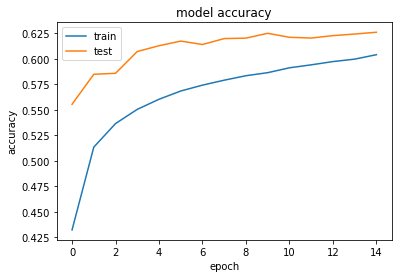

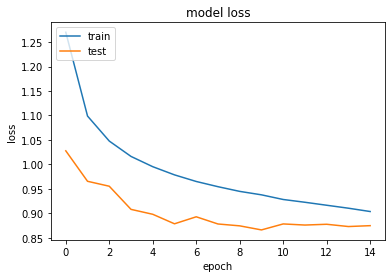

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save('model_normal_10epoch_totale.h5')

Finally we have the model trained, so we can test it using the data of the X_test.

In [ ]:
 predictions = model.predict(X_test)

In [ ]:
prediction_classes=np.argmax(predictions,axis=1)
prediction_classes

array([0, 0, 0, ..., 3, 0, 1])

One of the most important metrics we would like to see is the accuracy, in our case is not very high, probably for the small number of epochs, but it's not so bad considering than we have 5 classes.

In [ ]:
score, acc, *is_anything_else_being_returned = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)

print("acc: %.2f" % (acc))

196/196 - 64s - loss: 0.9226 - accuracy: 0.5991 - precision_5: 0.6378 - recall_5: 0.5374 - 64s/epoch - 326ms/step
acc: 0.60


We can visualize the confusion matrix also through a heatmap.


In [ ]:
from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
cf_matrix = confusion_matrix(Y_test.argmax(axis=1),prediction_classes)

In [ ]:
cf_matrix

array([[7944, 1674,  145,   61,  175],
       [2745, 5119, 1579,  354,  203],
       [ 449, 2274, 4102, 2667,  508],
       [ 120,  240, 1259, 5461, 2920],
       [ 125,   64,  188, 2294, 7329]])

In [ ]:
import seaborn as sns
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v2}\n{v3}" for v2, v3 in zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(5,5)

<AxesSubplot:>

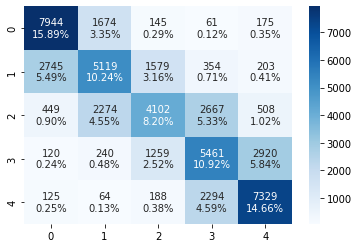

In [ ]:
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [ ]:
print(classification_report(Y_test.argmax(axis=1),prediction_classes))

              precision    recall  f1-score   support

           0       0.70      0.79      0.74      9999
           1       0.55      0.51      0.53     10000
           2       0.56      0.41      0.47     10000
           3       0.50      0.55      0.52     10000
           4       0.66      0.73      0.69     10000

    accuracy                           0.60     49999
   macro avg       0.59      0.60      0.59     49999
weighted avg       0.59      0.60      0.59     49999



The conclusion of this test is that our model it's not extremely good, it could be improved, but it needs more time to do that. Although for the extreme classes (1 and 5) it has a better performance respect to the others.

### <h1><center><strong>$$\color{#4740BF}{\text{Let's try it in action}}$$<strong>


We try with a single text of a review (written by us) to say how many stars would I assign to that.

In [ ]:
twt = ['The resturant was awful. nice waitress but hated the food']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=160, dtype='int32')   

In [ ]:
sentiment = model.predict(twt,verbose = 2)[0]  

1/1 - 0s - 62ms/epoch - 62ms/step


In [ ]:
print("review evaluated as", np.argmax(sentiment)+1, "out of 5")

review evaluated as 1 out of 5


The result seems to be right, the review was very bad and the algorithm recognize it.

## <h1><center><strong>$$\color{#4740BF}{\text{BiLSTM on 3 categories}}$$<strong>


Let's try with only 3 categories : positive, negative and neutral. We assigned to reviews with label 1 and 2 the **neg** class, to the ones with label 3 the **neut** class and to the ones with 4 or 5 the **pos** class. Since they were unbalanced we reblanced the classes.

In [ ]:
train1 = train
train1["cat"] = train1["label"]
train1["cat"].replace({1: "neg", 2: "neg", 3: "neut", 4: "pos", 5: "pos"}, inplace=True)
del train1["label"]

In [ ]:
test1 = test
test1["cat"] = test1["label"]
test1["cat"].replace({1: "neg", 2: "neg", 3: "neut", 4: "pos", 5: "pos"}, inplace=True)
del test1["label"]

For the train is better if we balance the classes, selecting a subset randomly, since at the end of the categorization we have unbalanced classes.

In [ ]:
from sklearn.utils import shuffle
pos_train_subset = train1[train1["cat"]=="pos"].sample(n=len(train1[train1["cat"]=="neut"]),random_state=28)
neut_train_subset = train1[train["cat"]=="neut"]
neg_train_subset = train1[train1["cat"]=="neg"].sample(n=len(train1[train1["cat"]=="neut"]),random_state=98)
print("pos", pos_train_subset.shape, "neu", neut_train_subset.shape, "neg",neg_train_subset.shape)
train_sub = shuffle(pd.concat([pos_train_subset, neut_train_subset, neg_train_subset], ignore_index = True))
train_sub.reset_index(drop=True, inplace=True)

In [ ]:
df_sub = pd.concat([train_sub, test], ignore_index = True)

We proceed in the same way as above. We use Tokenizer, then we transform into pad sequences and we create an embedding matrix using GloVe in order to have it for the embedding layer of the model.

In [ ]:
tokenizer2 = Tokenizer() 

In [ ]:
tokenizer2.fit_on_texts(df_sub['review'].values)

In [ ]:
X = tokenizer2.texts_to_sequences(df_sub['review'].values) 
print(X[0:4]) 

[[1728, 16818, 6087, 13890, 112, 491, 881, 2548, 2548, 112, 5088, 12773, 45028, 1186, 95, 447, 9486, 4533, 112], [118, 24, 64132, 256, 3278, 2383, 4571, 41, 387, 2968, 10, 2433, 4003, 2747, 10, 1189, 1851, 2046, 10199, 287, 4184, 287, 321, 275, 215, 6, 4890, 219, 554, 131, 3836, 1248, 1847, 5312, 491, 5573, 57, 2986, 262, 7790, 7269, 148, 1867, 2524], [459, 2730, 2833, 124, 117, 114, 252, 23, 1970, 2, 29, 23, 121, 128, 9429, 23, 1, 11819, 23, 128, 1, 684, 1224, 776, 23, 114, 153], [420, 2227, 12774, 939, 1844, 115, 4877, 5, 482, 3136, 692, 5, 2018, 6, 2640, 3332, 62, 1844, 1233, 7500, 8255, 17, 52, 216, 1115, 33, 8735, 23, 1844]]


In [ ]:
vocabulary_size = len(tokenizer2.word_counts)

In [ ]:
leng = []
for i in X:
  leng.append(len(i))

In [ ]:
import pandas as pd
s = pd.Series(leng)
s.describe() 

count    439987.000000
mean         62.796830
std          55.756518
min           0.000000
25%          25.000000
50%          47.000000
75%          82.000000
max         871.000000
dtype: float64

In [ ]:
X = pad_sequences(X, maxlen=160)

In [ ]:
X_train = X[:train_sub.shape[0]]
X_test = X[train_sub.shape[0]:]

In [ ]:
Y_train = pd.get_dummies(train_sub['cat']).values #Convert categorical variable into dummy/indicator variables.
Y_test = pd.get_dummies(test['cat']).values

We fit the same model, only changing the number of output in the last layer, from 5 to 3.

In [ ]:
embeddings_index = {}
embed_dim=100
word_index = tokenizer2.word_index
with open('/Users/fra/Desktop/progetto text mining/glove.6B.100d.txt', "r", encoding='iso-8859-1') as f:
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            continue
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))
embedding_matrix = np.zeros((len(word_index)+1, embed_dim))

for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # words not found in embedding index will be all-zeros.
    embedding_matrix[i] = embedding_vector
    
glove_matrix = embedding_matrix

Found 399884 word vectors.


In [ ]:
embed_dim =  100
lstm_out = 100 
maxlen = 160
glove_matrix = embedding_matrix

model = Sequential()

model.add(Embedding(vocabulary_size+1, 
                    embed_dim, 
                    weights=[glove_matrix], 
                    input_length=maxlen,
                    trainable=True, mask_zero=True))

model.add(Dropout(0.7))

model.add(Bidirectional(LSTM(lstm_out, dropout=0.7)))

model.add(Dense(3, activation='softmax'))
    
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',
                       Precision(),
                       Recall()])
model.summary()

early_stopping_callback = EarlyStopping(monitor="loss", min_delta=0.001, 
                                        patience=3, verbose=1, mode="auto", 
                                        restore_best_weights=True)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 160, 100)          18727600  
                                                                 
 dropout_6 (Dropout)         (None, 160, 100)          0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 200)              160800    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 3)                 603       
                                                                 
Total params: 18,889,003
Trainable params: 18,889,003
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
batch_size = 256
# Fit the model
history = model.fit(X_train, 
                    Y_train, 
                    batch_size=batch_size, 
                    epochs=15,
                    verbose=0,
                    validation_split=0.33,
                    callbacks=[early_stopping_callback]
                   )

CPU times: user 18h 4min 16s, sys: 5h 14min 33s, total: 23h 18min 50s
Wall time: 7h 20min 25s


dict_keys(['loss', 'accuracy', 'precision_6', 'recall_6', 'val_loss', 'val_accuracy', 'val_precision_6', 'val_recall_6'])


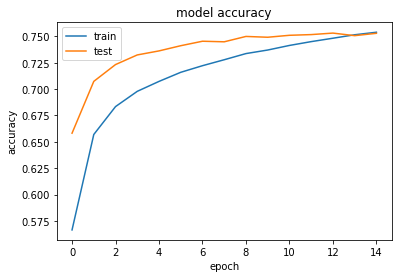

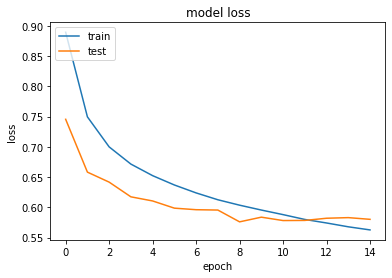

In [ ]:
# list all data in history
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save('model_3cat_10epoch_totale.h5')

We perform prediction.

In [ ]:
predictions = model.predict(X_test)
prediction_classes=np.argmax(predictions,axis=1)
prediction_classes

array([0, 0, 0, ..., 2, 0, 0])

In [ ]:
score,acc, *anything_else = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)

print("acc: %.2f" % (acc))

196/196 - 64s - loss: 0.5461 - accuracy: 0.7624 - precision_6: 0.7728 - recall_6: 0.7496 - 64s/epoch - 325ms/step
acc: 0.76


In [ ]:
from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
cf_matrix = confusion_matrix(Y_test.argmax(axis=1),prediction_classes)

In [ ]:
cf_matrix

array([[15260,  4224,   515],
       [ 1373,  6860,  1767],
       [  370,  3633, 15997]])

<AxesSubplot:>

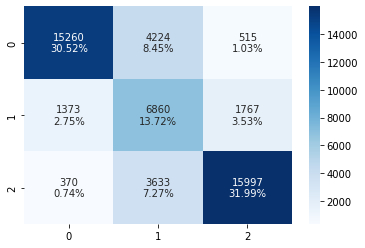

In [ ]:
import seaborn as sns

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v2}\n{v3}" for v2, v3 in zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(3,3)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [ ]:
print(classification_report(Y_test.argmax(axis=1),prediction_classes))

              precision    recall  f1-score   support

           0       0.90      0.76      0.82     19999
           1       0.47      0.69      0.56     10000
           2       0.88      0.80      0.84     20000

    accuracy                           0.76     49999
   macro avg       0.75      0.75      0.74     49999
weighted avg       0.80      0.76      0.78     49999



As we can see the performance is better than the one with 5 categories, we reach 76% of accuracy but it's not a good measure for unbalanced classes, so it's better to look at the weighted average of precision and recall that are even higher.